# Logistic Regression

Logistic Regression is generally used for classification purposes. Logistic regression uses a sigmoid or “logit” activation function. In this program, a logistic regression model to predict whether a student gets admitted into a university is built.The data used in this program has been taken from Andrew Ng’s Machine Learning course on Coursera. 
The data consists of marks of two exams for 100 applicants. The target value takes on binary values 1,0. 1 means the applicant was admitted to the university whereas 0 means the applicant didn't get an admission. The objective is to build a classifier that can predict whether an application will be admitted to the university or not.

## Import Packages

In [30]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Data

In [31]:
# Load iris dataset from python scikit-learn
exam_scores = pd.read_csv('exam_scores.txt', header = None, names = ['Score 1','Score 2','Status'])
categories = ['Not Admitted','Admitted']
exam_scores['Status'] = pd.Categorical.from_codes(exam_scores['Status'], categories)
exam_scores.head()

,Score 1,Score 2,Status
0,34.623660,78.024693,Not Admitted
1,30.286711,43.894998,Not Admitted
2,35.847409,72.902198,Not Admitted
3,60.182599,86.308552,Admitted
4,79.032736,75.344376,Admitted


In [32]:
# Information of  the dataset
exam_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Score 1    100 non-null float64
Score 2    100 non-null float64
Status     100 non-null category
dtypes: category(1), float64(2)
memory usage: 1.8 KB


In [33]:
# Check for missing values
data_missing = exam_scores.isnull().sum()
data_missing

Score 1    0
Score 2    0
Status     0
dtype: int64

## Data Exploration

In [34]:
# Analysis of Numerical data
exam_scores.describe()

,Score 1,Score 2
count,100.000000,100.000000
mean,65.644274,66.221998
std,19.458222,18.582783
min,30.058822,30.603263
25%,50.919511,48.179205
50%,67.032988,67.682381
75%,80.212529,79.360605
max,99.827858,98.869436


In [35]:
# Frquency of Categorical Values
exam_scores['Status'].value_counts()

Admitted        60
Not Admitted    40
Name: Status, dtype: int64

## Data Visualization

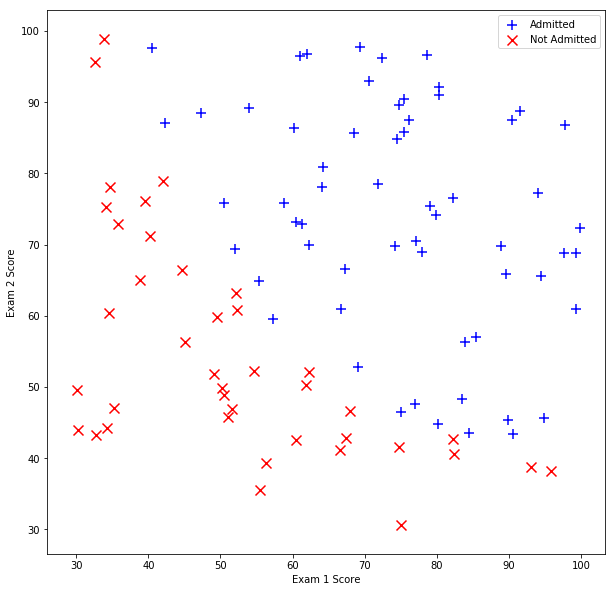

In [36]:
# Scatter Plot of the data
admitted = exam_scores[exam_scores['Status'] == 'Admitted']
not_admitted = exam_scores[exam_scores['Status'] == 'Not Admitted']

plt.figure(figsize =(10,10))
plt.scatter(admitted['Score 1'], admitted['Score 2'], s = 100, c = 'b', marker = '+', label = 'Admitted')
plt.scatter(not_admitted['Score 1'], not_admitted['Score 2'], s = 100, c='r', marker='x', label='Not Admitted')
plt.legend()
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.show()

#### __Insights:__
From this plot it can see that there is almost a linear decision boundary, but it curves a bit so a logistic regression model needs to be modelled. 

## Data Preparation

In [37]:
# Features for the model
features = ['Score 1', 'Score 2']
X = exam_scores[features]
# Add a column of ones for matrix multiplication
X.insert(0,'Intercept',1)
X = np.array(X.values)
print(X[0:5])

# Target for the model

# Categorial to numeric
y = preprocessing.LabelEncoder().fit(exam_scores['Status']).transform(exam_scores['Status'])

print(y)

# Initialize fitting parameters
theta = np.zeros(X.shape[1])
theta

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]]
[1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]


array([0., 0., 0.])

## Logistic Regression using Cost Function

Next, the logistic regression model needs to be implemented. Therefore the model is trained to find the optimal decision boundary and make class predictions. The first step is to implement the sigmoid function.

#### __Sigmoid Function__

The sigmoid function is the “activation” function for the output of logistic regression. It converts a continuous input into a value between zero and one. 

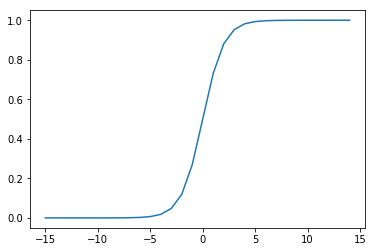

In [38]:
# Define the sigmoid function
def sigmoid(z):
    fn = 1. / (1 + np.exp(-z))
    return fn


# Plot the function
value = np.arange(-15, 15, step=1)
plt.plot(value, sigmoid(value))

#### __Cost Function__

The next step is to write the cost function. The cost function evaluates the performance of the model on the training data given a set of model parameters. 
The accuracy of the hypothesis function h(x)is measured using a cost function. The hypothesis for logistic regression can computed as:
$$
ℎ_\theta(𝑥) = sigmoid(\frac{1}{1+e^{\theta^TX}})
$$

The cost function can be computed as:
$$
cost(ℎ(𝑥)) = \frac{1}{m} (-ylogh(x) - (1 - y)log(1 - h(x)))
$$

where m is the number of training samples. 

It is the vectorized implementation. Cost function is also called 'Squared Error Function' or'Mean Squared Error'.

In [39]:
# Define the cost function
def cost_function(theta, X, y):
    
    m = X.shape[0]
    h = sigmoid(np.dot(X,theta))
    J = (1 / m) * np.sum(-y.T * np.log(h) - (1 - y).T * np.log(1 - h))
    return J

# Compute the cost function
result_costfn = cost_function(theta, X, y)

print("Initial Cost is ",result_costfn)

Initial Cost is  0.6931471805599453


#### __Gradient Function__

The gradient of the model parameters is computed to minimize the cost function. At each training iteration the parameters  are updated such that the cost is reduced and move in a direction until the minimum is reached. The cost function is differentiable. The cost function is computed as:
$$
\theta = \frac{1}{m}X^T((h(x) - y)
$$


In [40]:
# Define the gradient function
def gradient(theta, X, y):
    
    m = X.shape[0]
    h = sigmoid(np.dot(X,theta))
    grad = (1 /m) * np.dot(X.T , (h - y))
    return grad

# Compute the gradient function
result_gradient = gradient(theta, X, y)

print("Gradients are ", result_gradient)

Gradients are  [ 0.1        12.00921659 11.26284221]


#### __Learning parameters using fmin_tnc__

Until now, a cost function is computed and calculated its gradient. Next, the gradient descent steps are computed using a built-in function 'fmin_tnc' from scipy library. It can be used to compute the minimum for any function. fmin_tnc is an optimization solver that finds the minimum of an unconstrained function. For logistic regression, the cost function is optimized with the parameters theta.

In [41]:
# Optimize the cost function using fmin_tnc
result_optimize = opt.fmin_tnc(func = cost_function, x0 = theta, fprime = gradient, args = (X, y))

# Compute the optimized cost function
print("The solution using fmin_tnc is",result_optimize[0])
print("The Cost is ",cost_function(result_optimize[0], X, y))

The solution using fmin_tnc is [25.16131878 -0.20623159 -0.20147149]
The Cost is  0.20349770158947397


#### __Decision Boundary__

The optimized theta value will then be used to plot the decision boundary on the training data. The decision boundary can be found by setting the weighted sum of inputs to 0. 
$$
h(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2
$$

Equating h(x) to 0 gives,
$$
x_2 = -\frac{\theta_0 + \theta_1 x_1}{\theta_2}
$$


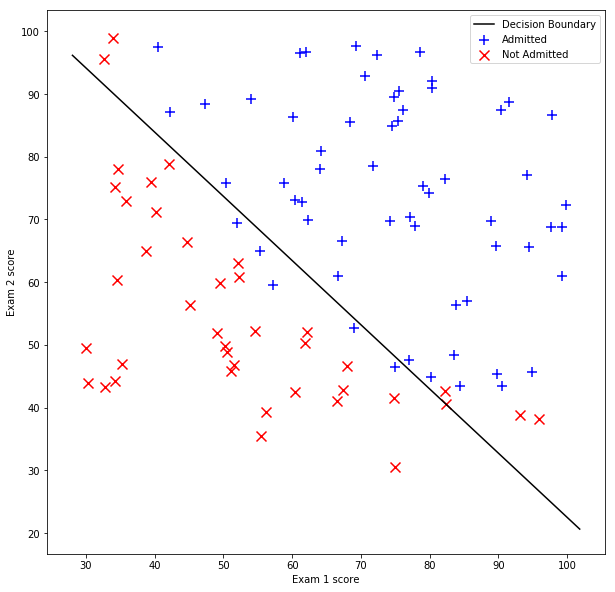

In [42]:
# X-coordinates of the decision boundary
plot_x = [np.min(X[:, 1] - 2), np.max(X[:, 1] + 2)]
# Y-coordinates of the decision boundary
plot_y = -1/result_optimize[0][2]*(result_optimize[0][0] + np.dot(result_optimize[0][1],plot_x))

# Plot the Single Line Decision Boundary
plt.figure(figsize =(10,10))
plt.scatter(admitted['Score 1'], admitted['Score 2'], s=100, c='b', marker='+', label = 'Admitted')
plt.scatter(not_admitted['Score 1'], not_admitted['Score 2'], s=100, c='r', marker='x',label = 'Not Admitted')
plt.plot(plot_x, plot_y, c='k', label='Decision Boundary')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()


#### __Insights:__

It looks like the logistic regression has done a good job in predicting and distinguishing the students who got the admission and those who didn’t.

## Accuracy of the Model

In [43]:
def predict(theta, X):
    p= [sigmoid(np.dot(X,theta)) >= 0.5]
    return p

p = predict(result_optimize[0],X)

accuracy = np.mean(p== y.flatten())
print('The accuracy of the model is', accuracy * 100)

The accuracy of the model is 89.0


## Summary

A logistic regression model to predict whether a student gets admitted into a university is built. Here the cost function and gradient are computed. And using the in-built function 'fmin_tnc', gradient descent is calculated to optmize the theta value. And then the decision boundary is plotted and the accuracy is calculated. The accuracy of the model is 89%, which means the model has done a decent job in predicting classes.